In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import ipywidgets as wg
from ipywidgets import interact
from IPython.display import display
import networkx as nx
from src.environment import Environment, EnvironmentMeanField
from src.runner import runner
from sklearn import preprocessing
import random
import json
import os

In [2]:
style.use('seaborn-white')

# Initialise small 1 district model

In [3]:
TIME = 60

In [4]:
age_groups = ['age_0_10', 'age_10_20', 'age_20_30', 'age_30_40', 'age_40_50', 
              'age_50_60', 'age_60_70', 'age_70_80', 'age_80_plus']

In [5]:
parameters = {
    # general simulation parameters
    "time": TIME,
    "number_of_agents": 1000,
    "monte_carlo_runs": 1,
    "data_output": 'csv', # 'csv' or 'network', or 'False'
    # specific simulation parameters
    "share_inital_agents_infected": 0.01, # percentage of agents infected randomly at the start of the simulation
    "exposed_days": 4, # average number of days without symptoms and being able to infect others
    "asymptom_days": 10, # average number of days agents are infected but do not have symptoms
    "symptom_days": 10,# average number of days agents have mild symptoms
    "critical_days": 8, # average number of days agents are in critical condition
    "health_system_capacity": 0.0021, # relative (in terms of population) capacity of the hospitals
    "no_hospital_multiplier": 1.79, # the increase in probability if a critical agent cannot go to the hospital SOURCE: Zhou et al. 2020
    "travel_sample_size": 0.01, # amount of agents that an agent might choose to travel to
    "foreign_infection_days": [x for x in range(0, 19)], # days at which 1 agent will be infected every day from abroad 
    # agent parameters
    "probability_transmission": 0.30, # should be estimated to replicate realistic R0 number.
    "probability_to_travel": 0.1, # should be estimated to replicate travel data 
    "probability_symptomatic": 0.75, # determines whether an agent will become asymptomatic or asymptomatic spreader
    "probability_critical": {key:value for key, value in zip(age_groups, [0.001, 0.003, 0.012, 0.032, 0.049, 0.102, 0.166, 0.244, 0.273])}, # probability that an agent enters a critical stage of the disease SOURCE: Verity et al.
    "probability_to_die": {key:value for key, value in zip(age_groups, [0.005, 0.021, 0.053, 0.126, 0.221, 0.303, 0.565, 0.653, 0.765])}, # probability to die per age group in critical stage SOURCE: Verity et al.
    "probability_susceptible": 0.000, # probability that the agent will again be susceptible after having recovered
    # Experiment parameter
    "lockdown_days" : [0 for x in range(0, TIME)], # in the baseline this is 0, 5 march was the first reported case, 27 march was the start of the lockdown 35 days
    # (1) physical distancing measures such as increased hygiëne & face mask adoption 
    "physical_distancing_multiplier": 0.27, # Jarvis et al. 2020,
    # (2) reducing travel e.g. by reducing it for work, school or all
    #"travel_restrictions_multiplier": 1.0 - ((0.85 + 0.62) / 2), # need estimate for this based on apple travel data reduction of 85% google work of -62% for Western Cape
    "travel_restrictions_multiplier": {key:value for key, value in zip(age_groups, 
                                                                       [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])},
    #'reduced_travel_groups': age_groups,
    # (3) reducing close contacts 
    "visiting_close_contacts_multiplier": 0.8, # depending on how strict the lockdown is at keeping you put.
    # (4) Testing and general awareness
    'likelihood_awareness': 0.2, # this will be increased through track & trace and coviid
    'self_isolation_multiplier': 0.4, # determines the percentage of connections cut thanks to self-isoluation can go up with coviid
    'aware_status': ['i2'], # i1 can be added if there is large scale testing 
    # (5) limiting mass contact e.g. forbidding large events
    "gathering_max_contacts": 4,
    # specific experiment 
    "informality_dummy": 0.0, # setting this parameter at 0 will mean the lockdown is equally effective anywhere, alternative = 1
    #"at_risk_groups": age_groups # list all age groups for baseline
}

In [6]:
districts_data = [[1, {'Population': parameters['number_of_agents'],
                                                 'Density': 1.0,
                                                 'lon': 1.0,
                                                 'lat': 1.0,
                                                 'Informal_residential': 0.0,
                                                 'Cases_With_Subdistricts': 1.0,
                                                }]]

In [7]:
distribution =  [0.112314, 0.118867, 0.145951, 0.145413, 0.151773, 0.139329, 0.099140, 0.058729, 0.028484]

Age distribution per district only has one district and accompanying distribution. 

In [8]:
age_distribution_per_district = {1: pd.Series(distribution, index=age_groups)}

The distance matrix is empty in this version of the model since there is only one district. 

In [9]:
distance_matrix = {districts_data[0][0]: [0.0]}
distance_matrix = pd.DataFrame(distance_matrix).transpose()
distance_matrix.columns = [districts_data[0][0]]

In [10]:
data_folder = 'measurement/simple/'

if not os.path.exists('{}seed{}'.format(data_folder, 0)):
    os.makedirs('{}seed{}'.format(data_folder, 0))

# Interactive simulation

In [11]:
# @interact
# def simulate_model(transmission_probability=(0.0, 0.1, 0.05), 
#                    lockdown=['phase5', 'phase4', 'phase3', 'phase2', 'phase1']):
#     parameters['probability_transmission'] = transmission_probability
#     parameters['lockdown_days'] = [0 for x in range(0, 46)]
#     lockdown_effect = {'phase5': 0.27, 'phase4': 0.30, 'phase3': 0.40, 'phase2': 0.50, 'phase1': 0.66}
#     print('assumed % of interactions', lockdown_effect)
#     print()
#     parameters["lockdown_infection_multiplier"] = lockdown_effect[lockdown]
    
#     #acti_effect_lockdown = {'phase5': -0.8, 'phase4': -0.7, 'phase3': -0.6, 'phase2': -0.5, 'phase1': -0.4}
#     # simulate baseline
    
#     environment = Environment(0, parameters, districts_data, age_distribution_per_district, distance_matrix)
#     environment = runner(environment, 0, data_folder=data_folder, data_output=parameters["data_output"])
    
#     for idx, network in enumerate(environment.infection_states):
#         for i, node in enumerate(network.nodes):
#             network.nodes[i]['agent'] = network.nodes[i]['agent'].status
            
#     susceptible_ot = []
#     infected_1_ot = []
#     infected_2_ot = []
#     critical_ot = []
#     dead_ot = []
#     recovered_ot = []

#     for t in range(parameters['time']):
#         network = environment.infection_states[t]
#         susceptible = 0
#         infected_1 = 0
#         infected_2 = 0
#         critical = 0
#         dead = 0
#         recovered = 0
#         for idx, node in enumerate(network):
#             if network.nodes[idx]['agent'] == 's':
#                 susceptible += 1
#             elif network.nodes[idx]['agent'] == 'i1':
#                 infected_1 += 1
#             elif network.nodes[idx]['agent'] == 'i2':
#                 infected_2 += 1
#             elif network.nodes[idx]['agent'] == 'c':
#                 critical += 1
#             elif network.nodes[idx]['agent'] == 'd':
#                 dead += 1
#             elif network.nodes[idx]['agent'] == 'r':
#                 recovered +=1
#             else:
#                 print('no status?')

#         susceptible_ot.append((susceptible / float(len(network))))
#         infected_1_ot.append((infected_1 / float(len(network))))
#         infected_2_ot.append((infected_2 / float(len(network))))
#         critical_ot.append((critical / float(len(network))))
#         dead_ot.append((dead / float(len(network))))
#         recovered_ot.append((recovered / float(len(network))))
            
#     # simulate lockdown 
#     parameters['lockdown_days'] = [x for x in range(0, 46)]
    
#     environment_l = Environment(0, parameters, districts_data, age_distribution_per_district, distance_matrix)
#     environment_l = runner(environment_l, 0, data_folder=data_folder, data_output=parameters["data_output"])
    
#     for idx, network_l in enumerate(environment_l.infection_states):
#         for i, node in enumerate(network_l.nodes):
#             network_l.nodes[i]['agent'] = network_l.nodes[i]['agent'].status
            
#     susceptible_ot_l = []
#     infected_1_ot_l = []
#     infected_2_ot_l = []
#     critical_ot_l = []
#     dead_ot_l = []
#     recovered_ot_l = []

#     for t in range(parameters['time']):
#         network = environment_l.infection_states[t]
#         susceptible = 0
#         infected_1 = 0
#         infected_2 = 0
#         critical = 0
#         dead = 0
#         recovered = 0
#         for idx, node in enumerate(network):
#             if network.nodes[idx]['agent'] == 's':
#                 susceptible += 1
#             elif network.nodes[idx]['agent'] == 'i1':
#                 infected_1 += 1
#             elif network.nodes[idx]['agent'] == 'i2':
#                 infected_2 += 1
#             elif network.nodes[idx]['agent'] == 'c':
#                 critical += 1
#             elif network.nodes[idx]['agent'] == 'd':
#                 dead += 1
#             elif network.nodes[idx]['agent'] == 'r':
#                 recovered +=1
#             else:
#                 print('no status?')

#         susceptible_ot_l.append((susceptible / float(len(network))))
#         infected_1_ot_l.append((infected_1 / float(len(network))))
#         infected_2_ot_l.append((infected_2 / float(len(network))))
#         critical_ot_l.append((critical / float(len(network))))
#         dead_ot_l.append((dead / float(len(network))))
#         recovered_ot_l.append((recovered / float(len(network))))
    
    
#     # plot figure
    
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

#     x = [x for x in range(parameters['time'])]

#     labels = ['critical', 'infected-2', 'infected-1', 'recovered', 'susceptible', 'dead']

#     y = np.vstack([critical_ot, infected_2_ot, infected_1_ot, recovered_ot, susceptible_ot, dead_ot])

#     ax1.axhline(parameters['health_system_capacity'], color='black')

#     pal = ["#f9b4ad", "#1b81c2", "#91b7d1", "#b7f0a5", "#e0e4ec","#000000"]

#     ax1.stackplot(x, y, colors= pal, labels=labels)
#     ax1.legend(loc='best', fontsize='14', frameon=True)
#     ax1.set_ylabel('Cape Town population', fontsize='14')
    
#     y2 = np.vstack([critical_ot_l, infected_2_ot_l, infected_1_ot_l, recovered_ot_l, susceptible_ot_l, dead_ot_l])
#     ax2.stackplot(x, y2, colors= pal, labels=labels)
    
#     for ax in [ax1, ax2]:
#         ax1.set_xlabel('Days', fontsize='14')
        
#     columns = ['total dead', 'peak critical', 'total recovered']
#     experiment_summary = {'1 baseline': [dead_ot[-1], max(critical_ot), recovered_ot[-1]],
#                       '1 (relative)': [100, 100, 100],
#                       '2 {}'.format(lockdown): [dead_ot_l[-1], max(critical_ot_l), recovered_ot_l[-1]],
#                       '2 (relative)': [dead_ot_l[-1] / dead_ot[-1], max(critical_ot_l) / max(critical_ot), recovered_ot_l[-1] / recovered_ot[-1]]
#                      }
#     experiment_summary = pd.DataFrame(experiment_summary).transpose()
#     experiment_summary.columns = columns
    
#     print(experiment_summary.round(2))


# Simulation

In [12]:
data_folder = 'measurement/simple/'

if not os.path.exists('{}seed{}'.format(data_folder, 0)):
    os.makedirs('{}seed{}'.format(data_folder, 0))
    
environment = Environment(0, parameters, districts_data, age_distribution_per_district, distance_matrix)
environment2 = EnvironmentMeanField(0, parameters, districts_data, age_distribution_per_district, distance_matrix)
#environment = runner(environment, 0, data_folder=data_folder)

BA edges =  1996
NG edges =  1996


## Properties of network

Density

In [13]:
print("BA {} agent Network density:".format(parameters['number_of_agents']), nx.density(environment.network))
print("R {} agent Network density:".format(parameters['number_of_agents']), nx.density(environment2.network))

BA 1000 agent Network density: 0.003995995995995996
R 1000 agent Network density: 0.003995995995995996


In [14]:
print("BA {} agent Network density:".format(parameters['number_of_agents']), nx.density(environment.network))
print("R {} agent Network density:".format(parameters['number_of_agents']), nx.density(environment2.network))

BA 1000 agent Network density: 0.003995995995995996
R 1000 agent Network density: 0.003995995995995996


Diameter (which is the longest of all shortest paths)

In [15]:
print("BA {} agent Network diameter:".format(parameters['number_of_agents']), nx.diameter(environment.network))
print("R {} agent Network diameter:".format(parameters['number_of_agents']), nx.diameter(environment2.network))

BA 1000 agent Network diameter: 7


NetworkXError: Found infinite path length because the graph is not connected

In [73]:
print("BA {} agent Network diameter:".format(parameters['number_of_agents']), nx.diameter(environment.network))
print("R {} agent Network diameter:".format(parameters['number_of_agents']), nx.diameter(environment2.network))

BA 15 agent Network diameter: 4
R 15 agent Network diameter: 3


Transitivity 

In [16]:
print("BA {} agent Network transitivity:".format(parameters['number_of_agents']), nx.transitivity(environment.network))
print("R {} agent Network transitivity:".format(parameters['number_of_agents']), nx.transitivity(environment2.network))

BA 1000 agent Network transitivity: 0.012426862734945374
R 1000 agent Network transitivity: 0.003435988801221685


In [59]:
print("BA {} agent Network transitivity:".format(parameters['number_of_agents']), nx.transitivity(environment.network))
print("R {} agent Network transitivity:".format(parameters['number_of_agents']), nx.transitivity(environment2.network))

BA 1000 agent Network transitivity: 0.012426862734945374
R 1000 agent Network transitivity: 0.0035


Compare how connected the nodes are:

In [17]:
from operator import itemgetter

### BA

In [18]:
degree_dict = dict(environment.network.degree(environment.network.nodes()))
nx.set_node_attributes(environment.network, degree_dict, 'degree')
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

In [19]:
print("Top 20 degrees of nodes BA 15 agents:")
for d in sorted_degree[:20]:
    print(d[1])

Top 20 degrees of nodes BA 15 agents:
100
49
39
39
38
30
30
29
27
27
26
26
22
22
21
20
20
19
19
19


In [20]:
print("Top 20 degrees of nodes BA 1000 agents:")
for d in sorted_degree[:20]:
    print(d[1])

Top 20 degrees of nodes BA 1000 agents:
100
49
39
39
38
30
30
29
27
27
26
26
22
22
21
20
20
19
19
19


### Random graph

In [21]:
degree_dict = dict(environment2.network.degree(environment2.network.nodes()))
nx.set_node_attributes(environment2.network, degree_dict, 'degree')
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

In [93]:
print("Top 20 degrees of nodes random 15 agents:")
for d in sorted_degree[:20]:
    print(d[1])

Top 20 degrees of nodes:
4
4
4
4
4
4
4
4
4
4
4
4
4
4


In [22]:
print("Top 20 degrees of nodes random 1000 agents:")
for d in sorted_degree[:20]:
    print(d[1])

Top 20 degrees of nodes random 1000 agents:
13
11
10
10
9
9
9
9
9
9
9
9
9
9
8
8
8
8
8
8


# Analysis

In [79]:
for idx, network2 in enumerate(environment2.infection_states):
    for i, node in enumerate(network2.nodes):
        network2.nodes[i]['agent'] = network2.nodes[i]['agent'].status

In [75]:
for idx, network in enumerate(environment.infection_states):
    for i, node in enumerate(network.nodes):
        network.nodes[i]['agent'] = network.nodes[i]['agent'].status

In [76]:
environment.network

In [81]:
pos2 = nx.spring_layout(environment2.network)#environment.infection_states[0])

In [77]:
pos = nx.spring_layout(environment.network)#environment.infection_states[0])

In [84]:
def plot_model(t):
    network = environment2.network#environment.infection_states[t]
    color_map = []
    for idx, node in enumerate(network):
        if network.nodes[idx]['agent'] == 's':
            color_map.append('blue')
        elif network.nodes[idx]['agent'] == 'i1':
            color_map.append('pink')
        elif network.nodes[idx]['agent'] == 'i2':
            color_map.append('red')
        elif network.nodes[idx]['agent'] == 'c':
            color_map.append('brown')
        elif network.nodes[idx]['agent'] == 'd':
            color_map.append('black')
        elif network.nodes[idx]['agent'] == 'r':
            color_map.append('grey')
    nx.draw(network, pos=pos, node_color=color_map, with_labels=True)

In [85]:
time_period = wg.IntSlider(description='Time step', min=0, max=parameters['time']-1)
wg.interact(plot_model, t=time_period)

interactive(children=(IntSlider(value=0, description='Time step', max=59), Output()), _dom_classes=('widget-in…

<function __main__.plot_model(t)>

In [78]:
time_period = wg.IntSlider(description='Time step', min=0, max=parameters['time']-1)
wg.interact(plot_model, t=time_period)

interactive(children=(IntSlider(value=0, description='Time step', max=59), Output()), _dom_classes=('widget-in…

<function __main__.plot_model(t)>

In [17]:
susceptible_ot = []
infected_1_ot = []
infected_2_ot = []
critical_ot = []
dead_ot = []
recovered_ot = []

for t in range(parameters['time']):
    network = environment.infection_states[t]
    susceptible = 0
    infected_1 = 0
    infected_2 = 0
    critical = 0
    dead = 0
    recovered = 0
    for idx, node in enumerate(network):
        if network.nodes[idx]['agent'] == 's':
            susceptible += 1
        elif network.nodes[idx]['agent'] == 'i1':
            infected_1 += 1
        elif network.nodes[idx]['agent'] == 'i2':
            infected_2 += 1
        elif network.nodes[idx]['agent'] == 'c':
            critical += 1
        elif network.nodes[idx]['agent'] == 'd':
            dead += 1
        elif network.nodes[idx]['agent'] == 'r':
            recovered +=1
        else:
            print('no status?')
    
    susceptible_ot.append((susceptible / float(len(network))))
    infected_1_ot.append((infected_1 / float(len(network))))
    infected_2_ot.append((infected_2 / float(len(network))))
    critical_ot.append((critical / float(len(network))))
    dead_ot.append((dead / float(len(network))))
    recovered_ot.append((recovered / float(len(network))))

(0, 1)

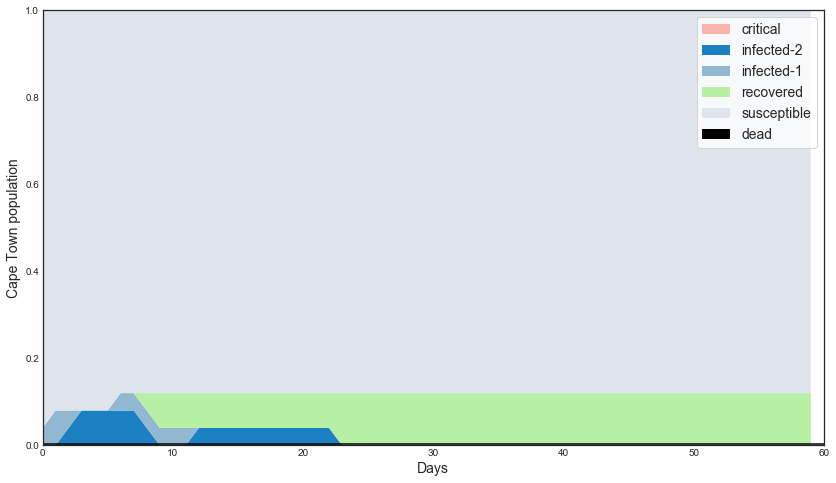

In [18]:
fig, ax = plt.subplots(figsize=(14,8))

x = [x for x in range(parameters['time'])]

labels = ['critical', 'infected-2', 'infected-1', 'recovered', 'susceptible', 'dead']

y = np.vstack([critical_ot, infected_2_ot, infected_1_ot, recovered_ot, susceptible_ot, dead_ot])

ax.axhline(parameters['health_system_capacity'], color='black')

pal = ["#f9b4ad", "#1b81c2", "#91b7d1", "#b7f0a5", "#e0e4ec","#000000"]

ax.stackplot(x, y, colors= pal, labels=labels)
ax.legend(loc='best', fontsize='14', frameon=True)
ax.set_ylabel('Cape Town population', fontsize='14')
ax.set_xlabel('Days', fontsize='14')

plt.xlim([0,parameters['time']])
plt.ylim([0, 1])

#fig.savefig('measurement/the_curve.png')